In [1]:
#normalizations
# tanh
# new plotting code

# Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import keras
import keras_metrics as km
import keras
import keras_metrics as km
from keras import metrics

2023-07-27 15:15:50.875925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Functions

In [2]:
#min-max normalize any array to between -1 and 1

def minmax(inputarray):
    
    
    #CHANGE normalize btwn the prior range
    
    absinput = np.abs(inputarray)
    gmax = absinput.max()
    newarray = inputarray / gmax
                
    return newarray, gmax


In [3]:
#return gammas back to original values in order to plot EOS

def unnorm(gammaarray, gam0max, gam1max, gam2max, gam3max):
    
    for i in range (len(gammaarray)):
        new_gamma0_array = gammaarray[0] * gam0max
        new_gamma1_array = gammaarray[1] * gam1max
        new_gamma2_array = gammaarray[2] * gam2max
        new_gamma3_array = gammaarray[3] * gam3max
    
    #gamma_array =  np.array([[0] * 4 ])
    new_gamma_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_gamma3_array), axis=1)

#        #change these values 
#        new_gamma0_array = ((gammaarray - gammaarray[0].min())/(gammaarray[0].max() - gammaarray[0].min())) * (2.0 - 0.2) + 0.2
#        new_gamma1_array = ((gammaarray - gammaarray[1].min())/(gammaarray[1].max() - gammaarray[1].min())) * (1.7 - (-1.6)) + (-1.6)
#        new_gamma2_array = ((gammaarray - gammaarray[2].min())/(gammaarray[2].max() - gammaarray[2].min())) * (0.6 - (-0.6)) + (-0.6)
#        new_gamma3_array = ((gammaarray - gammaarray[3].min())/(gammaarray[3].max() - gammaarray[3].min())) * (0.02 - (-0.02)) + (-0.02)
        
#        new_gamma_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_gamma3_array), axis=1)
        
    return new_gamma_array
    

In [4]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    gamma3 = data.pop('gamma3')
    gamma3 = np.array(gamma3)
    return gamma0, gamma1, gamma2, gamma3


In [5]:
def whiten(df):
    
    df_new = pd.DataFrame()
    for k in df.keys():
        df_new[k] = (df[k]-np.mean(df[k])) / np.std(df[k])
    return df_new

    #return (x - train_stats['mean']) / train_stats['std']

#  MLA

In [40]:
#inputs

m1_dat = np.loadtxt("m1.dat.txt", dtype=float)
m2_dat = np.loadtxt("m2.dat.txt", dtype=float)
l1_dat = np.loadtxt("l1.dat.txt", dtype=float)
l2_dat = np.loadtxt("l2.dat.txt", dtype=float)

#outputs

sd_gamma0 = np.loadtxt("sd_gamma0.dat.txt", dtype=float)
sd_gamma1 = np.loadtxt("sd_gamma1.dat.txt", dtype=float)
sd_gamma2 = np.loadtxt("sd_gamma2.dat.txt", dtype=float)
sd_gamma3 = np.loadtxt("sd_gamma3.dat.txt", dtype=float)


In [7]:
#normalize inputs

m1_dat, m1max = minmax(m1_dat)
m2_dat, m2max = minmax(m2_dat)
l1_dat, l1max = minmax(l1_dat)
l2_dat, l2max = minmax(l2_dat)


#normalize outputs

sd_gamma0, gam0max = minmax(sd_gamma0)
sd_gamma1, gam1max = minmax(sd_gamma1)
sd_gamma2, gam2max = minmax(sd_gamma2)
sd_gamma3, gam3max = minmax(sd_gamma3)


In [8]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 8 ] * 350)
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(350, 8)


In [9]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = sd_gamma3[i]
    

In [10]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'gamma3']
print(data)

           m1        m2        l1        l2    gamma0    gamma1    gamma2  \
0    0.717538  0.363692  0.013429  0.814641  0.820405  0.320176 -0.440481   
1    0.558854  0.569898  0.022247  0.032739  0.430324  0.687011 -0.728764   
2    0.475342  0.484010  0.008347  0.012574  0.165517  0.514935 -0.263242   
3    0.455285  0.458225  0.072287  0.100665  0.638727  0.149387 -0.061682   
4    0.464837  0.380781  0.044604  0.182299  0.245643  0.721879 -0.557980   
..        ...       ...       ...       ...       ...       ...       ...   
345  0.546255  0.458512  0.075708  0.269867  0.829332  0.343503 -0.514537   
346  0.590013  0.578357  0.014832  0.032980  0.748993  0.198778 -0.295988   
347  0.621068  0.528903  0.006943  0.039433  0.721593  0.036351 -0.017251   
348  0.700514  0.786345  0.011813  0.009212  0.822482  0.312064 -0.446830   
349  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

       gamma3  
0    0.486877  
1    0.763537  
2    0.113366  
3   -0.0532

In [11]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('gamma3')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

           m1        m2        l1        l2    gamma0    gamma1    gamma2  \
90   0.540071  0.501509  0.075892  0.161667  0.815307  0.325975 -0.463590   
123  0.503660  0.482053  0.057862  0.112224  0.798196  0.081510 -0.127035   
199  0.706075  0.625323  0.008899  0.036455  0.925006 -0.014461 -0.049392   
21   0.980120  0.993902  0.000843  0.002637  0.922852  0.134065 -0.202010   
258  0.592621  0.363230  0.014823  0.374597  0.599173  0.282742 -0.249635   
..        ...       ...       ...       ...       ...       ...       ...   
251  0.506923  0.346701  0.057201  0.662859  0.879554 -0.062807  0.036901   
332  0.586691  0.516930  0.030252  0.124057  0.791348  0.455497 -0.734388   
8    0.724003  0.706219  0.002683  0.008160  0.619791  0.309412 -0.310780   
65   0.717481  0.440628  0.004361  0.208840  0.608869  0.472742 -0.507782   
233  0.503799  0.428127  0.040594  0.173694  0.598196  0.414564 -0.485594   

       gamma3  
90   0.480763  
123  0.121898  
199  0.033795  
21   0.2129

In [12]:
#whitening
#norm_train_X = whiten(train)
#norm_test_X = whiten(test)

norm_train_X = train
norm_test_X = test

In [13]:
#normalizer = tf.keras.layers.Normalization(axis=-1)
#normalizer.adapt(train)

In [14]:
# build the model using the functional syntax

# output will be fed directly from the previous dense layer

act = 'tanh'

input_layer = Input(shape=(len(train .columns),))

#norm = normalizer(input_layer)

first_dense = Dense(units='128', activation=act)(input_layer)
second_dense = Dense(units='128', activation=act)(first_dense)
third_dense = Dense(units='128', activation=act)(second_dense)
fourth_dense = Dense(units='128', activation=act)(third_dense)
fifth_dense = Dense(units='128', activation=act)(fourth_dense)
sixth_dense = Dense(units='128', activation=act)(fifth_dense)
seventh_dense = Dense(units='128', activation=act)(sixth_dense)
eight_dense = Dense(units='128', activation=act)(seventh_dense)
ninth_dense = Dense(units='128', activation=act)(eight_dense)
    
tenth_dense = Dense(units='128', activation=act)(ninth_dense)
eleventh_dense = Dense(units='128', activation=act)(tenth_dense)
twelth_dense = Dense(units='128', activation=act)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=act)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=act)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=act)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=act)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=act)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=act)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=act)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=act)(nineteenth_dense)
tf_dense = Dense(units='128', activation=act)(twentieth_dense)
ts_dense = Dense(units='128', activation=act)(tf_dense)
tt_dense = Dense(units='128', activation=act)(ts_dense)
tfo_dense = Dense(units='128', activation=act)(tt_dense)
tfi_dense = Dense(units='128', activation=act)(tfo_dense)
ts_dense = Dense(units='128', activation=act)(tfi_dense)
tse_dense = Dense(units='128', activation=act)(ts_dense)
te_dense = Dense(units='128', activation=act)(tse_dense)
tn_dense = Dense(units='128', activation=act)(te_dense)


gamma0_output = Dense(units='1', activation=act, name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation=act)(tn_dense)

ths_dense = Dense(units='128', activation=act)(thf_dense)
tht_dense = Dense(units='128', activation=act)(ths_dense)
thfo_dense = Dense(units='128', activation=act)(tht_dense)
thfi_dense = Dense(units='128', activation=act)(thfo_dense)
ths_dense = Dense(units='128', activation=act)(thfi_dense)
thse_dense = Dense(units='128', activation=act)(ths_dense)
the_dense = Dense(units='128', activation=act)(thse_dense)
thn_dense = Dense(units='128', activation=act)(the_dense)

gamma1_output = Dense(units='1', activation=act, name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation=act)(thn_dense)

fof_dense = Dense(units='128', activation=act)(fo_dense)
fos_dense = Dense(units='128', activation=act)(fof_dense)
fot_dense = Dense(units='128', activation=act)(fos_dense)
fofo_dense = Dense(units='128', activation=act)(fot_dense)
fofi_dense = Dense(units='128', activation=act)(fofo_dense)

gamma2_output = Dense(units='1', activation=act, name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation=act)(fofi_dense)

fose_dense = Dense(units='128', activation=act)(fos_dense)
foe_dense = Dense(units='128', activation=act)(fose_dense)
fon_dense = Dense(units='128', activation=act)(foe_dense)
fif_dense = Dense(units='128', activation=act)(fon_dense)

gamma3_output = Dense(units='1', activation=act, name='gamma3_output')(fon_dense)

model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, gamma3_output])

print(model.summary())


2023-07-27 15:15:56.669883: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          640         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          16512       ['dense_1[0][0]']                
                                                                                              

 dense_39 (Dense)               (None, 128)          4224        ['dense_38[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 128)          16512       ['dense_39[0][0]']               
                                                                                                  
 dense_41 (Dense)               (None, 128)          16512       ['dense_40[0][0]']               
                                                                                                  
 dense_42 (Dense)               (None, 128)          16512       ['dense_41[0][0]']               
                                                                                                  
 dense_43 (Dense)               (None, 128)          16512       ['dense_42[0][0]']               
                                                                                                  
 dense_44 

In [15]:
#plot_model(model, to_file='V5_combinedmll.png', show_shapes=True, show_layer_names=True)

In [16]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'gamma3_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma3_output': tf.keras.metrics.MeanSquaredError()
                      })


endmetric = "mean_squared_error"


In [17]:
#train the model for a number of epochs

numepochs = 200
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=50,mode='auto')])

Epoch 1/200
23/23 [==============================] - 4s 36ms/step - loss: 0.2955 - gamma0_output_loss: 0.0758 - gamma1_output_loss: 0.0822 - gamma2_output_loss: 0.0667 - gamma3_output_loss: 0.0708 - gamma0_output_mean_squared_error: 0.0758 - gamma1_output_mean_squared_error: 0.0822 - gamma2_output_mean_squared_error: 0.0667 - gamma3_output_mean_squared_error: 0.0708 - val_loss: 0.4151 - val_gamma0_output_loss: 0.0806 - val_gamma1_output_loss: 0.1265 - val_gamma2_output_loss: 0.0968 - val_gamma3_output_loss: 0.1112 - val_gamma0_output_mean_squared_error: 0.0806 - val_gamma1_output_mean_squared_error: 0.1265 - val_gamma2_output_mean_squared_error: 0.0968 - val_gamma3_output_mean_squared_error: 0.1112
Epoch 2/200
23/23 [==============================] - 0s 16ms/step - loss: 0.2591 - gamma0_output_loss: 0.0558 - gamma1_output_loss: 0.0824 - gamma2_output_loss: 0.0602 - gamma3_output_loss: 0.0607 - gamma0_output_mean_squared_error: 0.0558 - gamma1_output_mean_squared_error: 0.0824 - gamma2_

Epoch 13/200
23/23 [==============================] - 0s 17ms/step - loss: 0.2337 - gamma0_output_loss: 0.0499 - gamma1_output_loss: 0.0726 - gamma2_output_loss: 0.0543 - gamma3_output_loss: 0.0569 - gamma0_output_mean_squared_error: 0.0499 - gamma1_output_mean_squared_error: 0.0726 - gamma2_output_mean_squared_error: 0.0543 - gamma3_output_mean_squared_error: 0.0569 - val_loss: 0.3605 - val_gamma0_output_loss: 0.0553 - val_gamma1_output_loss: 0.1055 - val_gamma2_output_loss: 0.0945 - val_gamma3_output_loss: 0.1051 - val_gamma0_output_mean_squared_error: 0.0553 - val_gamma1_output_mean_squared_error: 0.1055 - val_gamma2_output_mean_squared_error: 0.0945 - val_gamma3_output_mean_squared_error: 0.1051
Epoch 14/200
23/23 [==============================] - 0s 19ms/step - loss: 0.2246 - gamma0_output_loss: 0.0415 - gamma1_output_loss: 0.0703 - gamma2_output_loss: 0.0549 - gamma3_output_loss: 0.0578 - gamma0_output_mean_squared_error: 0.0415 - gamma1_output_mean_squared_error: 0.0703 - gamma

Epoch 25/200
23/23 [==============================] - 0s 17ms/step - loss: 0.2246 - gamma0_output_loss: 0.0443 - gamma1_output_loss: 0.0687 - gamma2_output_loss: 0.0543 - gamma3_output_loss: 0.0572 - gamma0_output_mean_squared_error: 0.0443 - gamma1_output_mean_squared_error: 0.0687 - gamma2_output_mean_squared_error: 0.0543 - gamma3_output_mean_squared_error: 0.0572 - val_loss: 0.3588 - val_gamma0_output_loss: 0.0450 - val_gamma1_output_loss: 0.1071 - val_gamma2_output_loss: 0.0988 - val_gamma3_output_loss: 0.1079 - val_gamma0_output_mean_squared_error: 0.0450 - val_gamma1_output_mean_squared_error: 0.1071 - val_gamma2_output_mean_squared_error: 0.0988 - val_gamma3_output_mean_squared_error: 0.1079
Epoch 26/200
23/23 [==============================] - 0s 17ms/step - loss: 0.2187 - gamma0_output_loss: 0.0416 - gamma1_output_loss: 0.0669 - gamma2_output_loss: 0.0532 - gamma3_output_loss: 0.0570 - gamma0_output_mean_squared_error: 0.0416 - gamma1_output_mean_squared_error: 0.0669 - gamma

Epoch 37/200
23/23 [==============================] - 0s 19ms/step - loss: 0.2117 - gamma0_output_loss: 0.0388 - gamma1_output_loss: 0.0633 - gamma2_output_loss: 0.0529 - gamma3_output_loss: 0.0567 - gamma0_output_mean_squared_error: 0.0388 - gamma1_output_mean_squared_error: 0.0633 - gamma2_output_mean_squared_error: 0.0529 - gamma3_output_mean_squared_error: 0.0567 - val_loss: 0.3514 - val_gamma0_output_loss: 0.0450 - val_gamma1_output_loss: 0.1051 - val_gamma2_output_loss: 0.0950 - val_gamma3_output_loss: 0.1064 - val_gamma0_output_mean_squared_error: 0.0450 - val_gamma1_output_mean_squared_error: 0.1051 - val_gamma2_output_mean_squared_error: 0.0950 - val_gamma3_output_mean_squared_error: 0.1064
Epoch 38/200
23/23 [==============================] - 0s 18ms/step - loss: 0.2219 - gamma0_output_loss: 0.0434 - gamma1_output_loss: 0.0678 - gamma2_output_loss: 0.0539 - gamma3_output_loss: 0.0569 - gamma0_output_mean_squared_error: 0.0434 - gamma1_output_mean_squared_error: 0.0678 - gamma

Epoch 49/200
23/23 [==============================] - 0s 11ms/step - loss: 0.2127 - gamma0_output_loss: 0.0373 - gamma1_output_loss: 0.0661 - gamma2_output_loss: 0.0531 - gamma3_output_loss: 0.0562 - gamma0_output_mean_squared_error: 0.0373 - gamma1_output_mean_squared_error: 0.0661 - gamma2_output_mean_squared_error: 0.0531 - gamma3_output_mean_squared_error: 0.0562 - val_loss: 0.3513 - val_gamma0_output_loss: 0.0445 - val_gamma1_output_loss: 0.1057 - val_gamma2_output_loss: 0.0956 - val_gamma3_output_loss: 0.1055 - val_gamma0_output_mean_squared_error: 0.0445 - val_gamma1_output_mean_squared_error: 0.1057 - val_gamma2_output_mean_squared_error: 0.0956 - val_gamma3_output_mean_squared_error: 0.1055
Epoch 50/200
23/23 [==============================] - 0s 14ms/step - loss: 0.2201 - gamma0_output_loss: 0.0387 - gamma1_output_loss: 0.0689 - gamma2_output_loss: 0.0544 - gamma3_output_loss: 0.0582 - gamma0_output_mean_squared_error: 0.0387 - gamma1_output_mean_squared_error: 0.0689 - gamma

Epoch 61/200
23/23 [==============================] - 0s 15ms/step - loss: 0.2148 - gamma0_output_loss: 0.0388 - gamma1_output_loss: 0.0664 - gamma2_output_loss: 0.0531 - gamma3_output_loss: 0.0565 - gamma0_output_mean_squared_error: 0.0388 - gamma1_output_mean_squared_error: 0.0664 - gamma2_output_mean_squared_error: 0.0531 - gamma3_output_mean_squared_error: 0.0565 - val_loss: 0.3436 - val_gamma0_output_loss: 0.0446 - val_gamma1_output_loss: 0.1003 - val_gamma2_output_loss: 0.0940 - val_gamma3_output_loss: 0.1047 - val_gamma0_output_mean_squared_error: 0.0446 - val_gamma1_output_mean_squared_error: 0.1003 - val_gamma2_output_mean_squared_error: 0.0940 - val_gamma3_output_mean_squared_error: 0.1047
Epoch 62/200
23/23 [==============================] - 0s 16ms/step - loss: 0.2161 - gamma0_output_loss: 0.0399 - gamma1_output_loss: 0.0662 - gamma2_output_loss: 0.0532 - gamma3_output_loss: 0.0568 - gamma0_output_mean_squared_error: 0.0399 - gamma1_output_mean_squared_error: 0.0662 - gamma

Epoch 73/200
23/23 [==============================] - 0s 13ms/step - loss: 0.2145 - gamma0_output_loss: 0.0396 - gamma1_output_loss: 0.0659 - gamma2_output_loss: 0.0531 - gamma3_output_loss: 0.0560 - gamma0_output_mean_squared_error: 0.0396 - gamma1_output_mean_squared_error: 0.0659 - gamma2_output_mean_squared_error: 0.0531 - gamma3_output_mean_squared_error: 0.0560 - val_loss: 0.3540 - val_gamma0_output_loss: 0.0444 - val_gamma1_output_loss: 0.1080 - val_gamma2_output_loss: 0.0963 - val_gamma3_output_loss: 0.1053 - val_gamma0_output_mean_squared_error: 0.0444 - val_gamma1_output_mean_squared_error: 0.1080 - val_gamma2_output_mean_squared_error: 0.0963 - val_gamma3_output_mean_squared_error: 0.1053
Epoch 74/200
23/23 [==============================] - 0s 17ms/step - loss: 0.2102 - gamma0_output_loss: 0.0380 - gamma1_output_loss: 0.0652 - gamma2_output_loss: 0.0516 - gamma3_output_loss: 0.0553 - gamma0_output_mean_squared_error: 0.0380 - gamma1_output_mean_squared_error: 0.0652 - gamma

Epoch 85/200
23/23 [==============================] - 0s 13ms/step - loss: 0.2079 - gamma0_output_loss: 0.0357 - gamma1_output_loss: 0.0636 - gamma2_output_loss: 0.0522 - gamma3_output_loss: 0.0563 - gamma0_output_mean_squared_error: 0.0357 - gamma1_output_mean_squared_error: 0.0636 - gamma2_output_mean_squared_error: 0.0522 - gamma3_output_mean_squared_error: 0.0563 - val_loss: 0.3513 - val_gamma0_output_loss: 0.0463 - val_gamma1_output_loss: 0.1050 - val_gamma2_output_loss: 0.0953 - val_gamma3_output_loss: 0.1048 - val_gamma0_output_mean_squared_error: 0.0463 - val_gamma1_output_mean_squared_error: 0.1050 - val_gamma2_output_mean_squared_error: 0.0953 - val_gamma3_output_mean_squared_error: 0.1048
Epoch 86/200
23/23 [==============================] - 0s 17ms/step - loss: 0.2056 - gamma0_output_loss: 0.0366 - gamma1_output_loss: 0.0625 - gamma2_output_loss: 0.0511 - gamma3_output_loss: 0.0553 - gamma0_output_mean_squared_error: 0.0366 - gamma1_output_mean_squared_error: 0.0625 - gamma

Epoch 97/200
23/23 [==============================] - 0s 15ms/step - loss: 0.2140 - gamma0_output_loss: 0.0385 - gamma1_output_loss: 0.0666 - gamma2_output_loss: 0.0528 - gamma3_output_loss: 0.0561 - gamma0_output_mean_squared_error: 0.0385 - gamma1_output_mean_squared_error: 0.0666 - gamma2_output_mean_squared_error: 0.0528 - gamma3_output_mean_squared_error: 0.0561 - val_loss: 0.3750 - val_gamma0_output_loss: 0.0648 - val_gamma1_output_loss: 0.1106 - val_gamma2_output_loss: 0.0952 - val_gamma3_output_loss: 0.1044 - val_gamma0_output_mean_squared_error: 0.0648 - val_gamma1_output_mean_squared_error: 0.1106 - val_gamma2_output_mean_squared_error: 0.0952 - val_gamma3_output_mean_squared_error: 0.1044
Epoch 98/200
23/23 [==============================] - 0s 13ms/step - loss: 0.2091 - gamma0_output_loss: 0.0369 - gamma1_output_loss: 0.0643 - gamma2_output_loss: 0.0522 - gamma3_output_loss: 0.0557 - gamma0_output_mean_squared_error: 0.0369 - gamma1_output_mean_squared_error: 0.0643 - gamma

In [35]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, gamma3_loss, gamma3_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)

3/3 [==============================] - 0s 11ms/step - loss: 0.2369 - gamma0_output_loss: 0.0609 - gamma1_output_loss: 0.0657 - gamma2_output_loss: 0.0520 - gamma3_output_loss: 0.0583 - gamma0_output_mean_squared_error: 0.0609 - gamma1_output_mean_squared_error: 0.0657 - gamma2_output_mean_squared_error: 0.0520 - gamma3_output_mean_squared_error: 0.0583


In [36]:
#predictions = model.predict(norm_test_X.to_numpy())

new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions, gam0max, gam1max, gam2max, gam3max)


9/9 [==============================] - 0s 6ms/step


In [21]:
len(predictions)

280

# EOS

In [22]:
length = len(predictions)

Progress : 0 / 280, 0.00%
Progress : 10 / 280, 3.57%
Progress : 20 / 280, 7.14%
Progress : 30 / 280, 10.71%
Progress : 40 / 280, 14.29%
Progress : 50 / 280, 17.86%
Progress : 60 / 280, 21.43%
Progress : 70 / 280, 25.00%
Progress : 80 / 280, 28.57%
Progress : 90 / 280, 32.14%
Progress : 100 / 280, 35.71%
Progress : 110 / 280, 39.29%
Progress : 120 / 280, 42.86%
Progress : 130 / 280, 46.43%
Progress : 140 / 280, 50.00%
Progress : 150 / 280, 53.57%
Progress : 160 / 280, 57.14%
Progress : 170 / 280, 60.71%
Progress : 180 / 280, 64.29%
Progress : 190 / 280, 67.86%
Progress : 200 / 280, 71.43%
Progress : 210 / 280, 75.00%
Progress : 220 / 280, 78.57%
Progress : 230 / 280, 82.14%
Progress : 240 / 280, 85.71%
Progress : 250 / 280, 89.29%
Progress : 260 / 280, 92.86%
Progress : 270 / 280, 96.43%


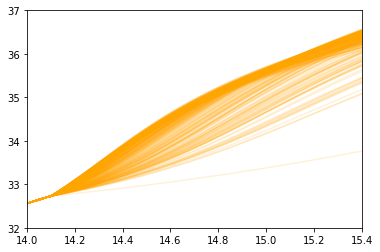

In [29]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):
    
    gam0 = float(predictions[i][0])
    gam1 = float(predictions[i][1])
    gam2 = float(predictions[i][2])
    gam3 = float(predictions[i][3])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    eos = lal.SimNeutronStarEOS4ParameterSpectralDecomposition(gam0,gam1,gam2,gam3)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='orange',alpha=0.15)

plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Actual EOS

In [37]:
length = len(sd_gamma0)

In [41]:
sd_gamma0[2]

0.24854513459025435

Progress : 0 / 350, 0.00%
Progress : 10 / 350, 2.86%
Progress : 20 / 350, 5.71%
Progress : 30 / 350, 8.57%
Progress : 40 / 350, 11.43%
Progress : 50 / 350, 14.29%
Progress : 60 / 350, 17.14%
Progress : 70 / 350, 20.00%
Progress : 80 / 350, 22.86%
Progress : 90 / 350, 25.71%
Progress : 100 / 350, 28.57%
Progress : 110 / 350, 31.43%
Progress : 120 / 350, 34.29%
Progress : 130 / 350, 37.14%
Progress : 140 / 350, 40.00%
Progress : 150 / 350, 42.86%
Progress : 160 / 350, 45.71%
Progress : 170 / 350, 48.57%
Progress : 180 / 350, 51.43%
Progress : 190 / 350, 54.29%
Progress : 200 / 350, 57.14%
Progress : 210 / 350, 60.00%
Progress : 220 / 350, 62.86%
Progress : 230 / 350, 65.71%
Progress : 240 / 350, 68.57%
Progress : 250 / 350, 71.43%
Progress : 260 / 350, 74.29%
Progress : 270 / 350, 77.14%
Progress : 280 / 350, 80.00%
Progress : 290 / 350, 82.86%
Progress : 300 / 350, 85.71%
Progress : 310 / 350, 88.57%
Progress : 320 / 350, 91.43%
Progress : 330 / 350, 94.29%
Progress : 340 / 350, 97.14%


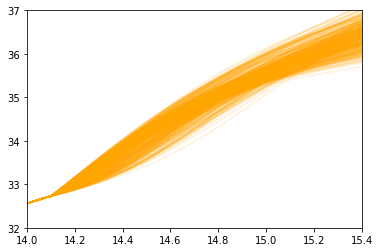

In [42]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):
    
    gam0 = float(sd_gamma0[i])
    gam1 = float(sd_gamma1[i])
    gam2 = float(sd_gamma2[i])
    gam3 = float(sd_gamma3[i])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    eos = lal.SimNeutronStarEOS4ParameterSpectralDecomposition(gam0,gam1,gam2,gam3)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='orange',alpha=0.15)

plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [27]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'gamma3_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'gamma3_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_gamma3_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_gamma3_output_mean_squared_error'])

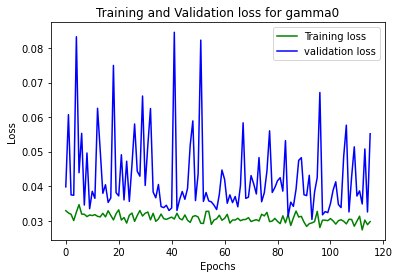

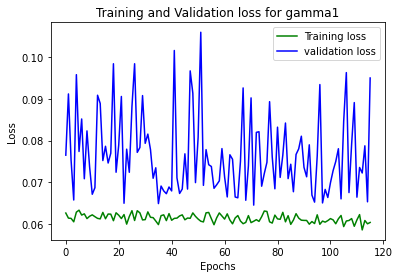

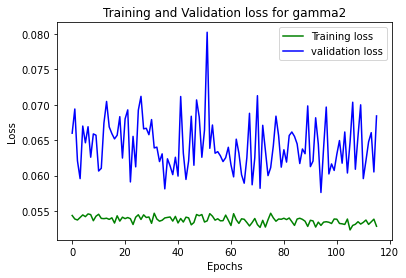

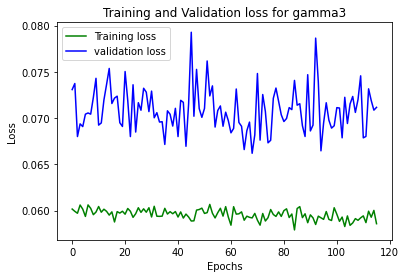

In [28]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma3 values
loss_train = history.history['gamma3_output_loss']
loss_val = history.history['val_gamma3_output_loss']
epochs = range(0,116)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Metric

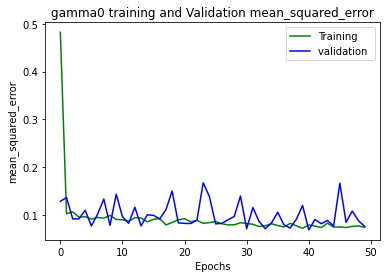

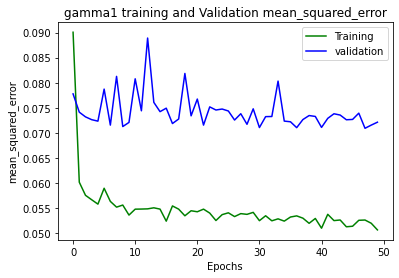

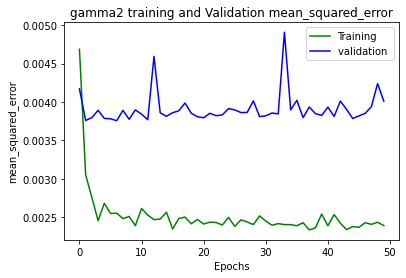

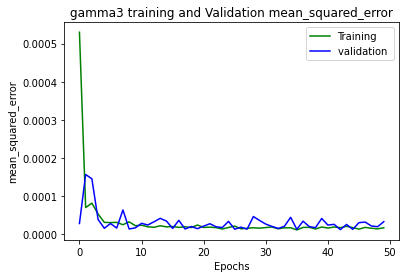

In [42]:
val = 'val_'
gam0out = 'gamma0_output_'
gam1out = 'gamma1_output_'
gam2out = 'gamma2_output_'
gam3out = 'gamma3_output_'

ac_train = history.history[gam0out + endmetric]
ac_val = history.history[val + gam0out + endmetric]
plt.plot(ac_train, 'g', label='Training')
plt.plot(ac_val, 'b', label='validation ')
plt.title('gamma0 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()



ac_train = history.history[gam1out + endmetric]
ac_val = history.history[val + gam1out + endmetric]
plt.plot(ac_train, 'g', label='Training')
plt.plot(ac_val, 'b', label='validation')
plt.title('gamma1 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()

ac_train = history.history[gam2out + endmetric]
ac_val = history.history[val + gam2out + endmetric]
plt.plot(ac_train, 'g', label='Training ',)
plt.plot(ac_val, 'b', label='validation ')
plt.title('gamma2 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()

ac_train = history.history[gam3out + endmetric]
ac_val = history.history[val + gam3out + endmetric]
plt.plot(ac_train, 'g', label='Training ')
plt.plot(ac_val, 'b', label='validation ')
plt.title('gamma3 training and Validation ' + endmetric)
plt.xlabel('Epochs')
plt.ylabel(endmetric)
plt.legend()
plt.show()